# Lab 3 - Clustering

## MSDS 7331-401

#### Project Team:
+ Peter Byrd 
+ Matthew Przybyla  
+ David Tran
+ Amber Whelpley

# National Highway Traffic Safety Administration - 2015 Traffic Accidents



## Business Understanding

A primary objective of the National Highway Traffic Safety Administration (NHTSA) is to reduce the staggering human toll and property damage caused by motor vehicle traffic crashes.  Each year, thousands of lives are lost, hundreds of thousands are injured, and billions of dollars are lost in property damage.  Understanding the factors related to automotive crashes is needed to design and implement programs that effectively reduce the impact on human lives and reduce the billions lost in damages.

In 1975, the Fatality Analysis Reporting System (FARS) began collecting information about fatal crashes involving all types of vehicles.  The FARS system is used to identify highway safety problem areas, and provide a basis for regulatory and consumer information initiatives.

FARS is directed by the National Center for Statistics and Analysis which is a component of NHTSA.  Trained state employees, called "FARS Analysts," are responsible for gathering, translating, and transmitting their States' data to NCSA.  FARS data are obtained from varius States' documents, such as:
+ Police Accident Reports
+ Death Certificates
+ State Vehicle Registration Files
+ Coroner/Medical Examiner Reports
+ State Drive Licensing Files
+ State Highway Department Data
+ Emergency Medical Services Reports
+ Vital Statistics and other State Records

All qualifying fatalities that occur within the 50 US states, District of Columbia, and Puerto Rico are recorded.  A qualifying case involves a motor vehicle traveling on a trafficway open to the public, and must have resulted in a death of a motorist or non-motorist within 30 days of the accident.

A desired outcome from analysis of the FARS data is to determine the primary causes associated with traffic fatalities and to drive awareness for prevention programs.  Identification of strong correlation between traffic fatalities and other recorded attributes such as weather, dates, or intoxication can lead to successful prevention measures.  

For the analysis performed here, we will focus on the *accident.csv* file found at https://www.kaggle.com/nhtsa/2015-traffic-fatalities. An effective model will determine the factors that lead to a higher death rate in fatal crashes. Our intention is to eventually use this data to assist in predicting whether an accident will have multiple fatalities using the information we have. We consider a successful outcome to be successful prediction approximately 80% of the time. Whether this goal is possible remains to be seen.

A successful prediction algorithm could be used to guide prevention programs toward awareness of certain factors that lead to a higher impact on human life.

### Import Data

In [19]:
import pandas as pd
import numpy as np
import datetime
from __future__ import print_function 

import warnings
#warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore')

import seaborn as sns
sns.set(style="white", color_codes=True)
import matplotlib.pyplot as plt

from scipy import special 


#Read the Data
df = pd.read_csv("/Users/pbyrd/Data/NHTSA/accident.csv")

#Review the data
df.head()

,STATE,ST_CASE,VE_TOTAL,VE_FORMS,PVH_INVL,PEDS,PERNOTMVIT,PERMVIT,PERSONS,COUNTY,...,NOT_MIN,ARR_HOUR,ARR_MIN,HOSP_HR,HOSP_MN,CF1,CF2,CF3,FATALS,DRUNK_DR
0,1,10001,1,1,0,0,0,1,1,127,...,99,2,58,88,88,0,0,0,1,1
1,1,10002,1,1,0,0,0,1,1,83,...,99,22,20,88,88,0,0,0,1,0
2,1,10003,1,1,0,0,0,2,2,11,...,99,1,45,99,99,0,0,0,1,1
3,1,10004,1,1,0,0,0,1,1,45,...,99,1,15,88,88,0,0,0,1,1
4,1,10005,2,2,0,0,0,2,2,45,...,99,7,16,88,88,0,0,0,1,0



## Data Understanding

The following sections will clean up some issues in the data.  We will remove invalid Latitude and Longitude coordinates, simplify the time of the crash to a single time value, and replace the state codes with the actual names of the states.  We will also combine attributes for persons involved in the accident, and create a few one-hot encoded attributes from Rural/Urban and Workzone.

New features were developed from the dataset.  The feature RUSH_HR was created to determine if rush hour traffic was a key factor in fatalities and collisions.  The feature lapseTime represents the time between the crash occuring and when EMS delivers the victim to the hospital, and could also be a factor in determining whether a fatality or collision occurred.

New ordinal variables were also created for lighting condition and weather condition.  The original variables for lighting (LGT_COND) was reordered to represent a new ordinal variable (light) to scale from lightest to darkest conditions.  Similarly, the original variable for weather condition (WEATHER) was reordered to represent a new ordinal variable (weather) to scale from best to worst weather conditions.


In [20]:
# Missing Latitude and Longitude data

# If 99.9999/88.8888/77.7777 and 999.9999/888.8888/777.7777 appear in the data we won't be able to graph them.
# We will make them 0 and we can omit them when mapping.

df['LATITUDE'] = df['LATITUDE'].replace(to_replace=99.9999,value=0) # replace unknown LATITUDE with 0 for mapping
df['LATITUDE'] = df['LATITUDE'].replace(to_replace=88.8888,value=0) # replace not available LATITUDE with 0 for mapping
df['LATITUDE'] = df['LATITUDE'].replace(to_replace=77.7777,value=0) # replace not reported LATITUDE with 0 for mapping

df['LONGITUD'] = df['LONGITUD'].replace(to_replace=999.9999,value=0) # replace unknown LONGITUD with 0 for mapping
df['LONGITUD'] = df['LONGITUD'].replace(to_replace=888.8888,value=0) # replace unknown LONGITUD with 0 for mapping
df['LONGITUD'] = df['LONGITUD'].replace(to_replace=777.7777,value=0) # replace unknown LONGITUD with 0 for mapping


In [21]:
# Add attribute for total time lapse between Crash time and Hospital arrival time

df['lapseTime'] = (df['HOSP_HR'] - df['HOUR'])*60 + (df['HOSP_MN'] - df['MINUTE'])
df['lapseTime'] = (df['lapseTime'] < 1440) * df['lapseTime'] # Keep only lapseTime less than a day (1440 mins)
df['lapseTime'] = (df['lapseTime'] > 0) * df['lapseTime']     # Remove lapseTime that are negative

In [22]:
# Naming the States 
# Reference: https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812315 - Page 93 

states = {1: 'Alabama', 2: 'Alaska', 3: 'American Samoa', 4: 'Arizona', 5: 'Arkansas', 
          6: 'California', 8: 'Colorado', 9: 'Connecticut', 10: 'Delaware', 11: 'District of Columbia',
          12: 'Florida', 13: 'Georgia',14: 'Guam', 15: 'Hawaii', 
          16: 'Idaho', 17: 'Illinois', 18: 'Indiana', 19: 'Iowa', 20: 'Kansas', 
          21: 'Kentucky', 22: 'Louisiana', 23: 'Maine', 24: 'Maryland', 
          25: 'Massachusetts', 26: 'Michigan', 27: 'Minnesota', 
          28: 'Mississippi', 29: 'Missouri', 30: 'Montana', 31: 'Nebraska', 
          32: 'Nevada', 33: 'New Hampshire', 34: 'New Jersey', 35: 'New Mexico', 
          36: 'New York', 37: 'North Carolina', 38: 'North Dakota', 39: 'Ohio', 
          40: 'Oklahoma', 41: 'Oregon', 42: 'Pennsylvania', 43: 'Puerto Rico', 
          44: 'Rhode Island', 45: 'South Carolina', 46: 'South Dakota', 47: 'Tennessee', 
          48: 'Texas', 49: 'Utah', 50: 'Vermont', 51: 'Virginia', 52: 'Virgin Islands', 
          53: 'Washington', 54: 'West Virginia', 55: 'Wisconsin', 56: 'Wyoming'}

df['state']=df['STATE'].apply(lambda x: states[x])

In [23]:
# Lighting Condition

# Order from best to worst lighting condition
lighting = {0:1, 1:1, 2:4, 3:3, 4:2, 5:2, 6:5, 7:6, 8:6, 9:6}

df['light']=df['LGT_COND'].apply(lambda x: lighting[x])

In [24]:
# Weather condition

# Order from best to worst weather condition
weathertype = {0:1, 1:1, 2:3, 3:5, 4:3, 5:4, 6:6, 7:6, 8:6, 9:6, 10:2 ,11:6 , 12:5, 98:7 , 99:7}

# New order:
#   No additional weather, Clear
#   Cloudy
#   Rain, Snow
#   Fog
#   Sleet/Hail, Freezing Rain
#   Severe crosswinds, Blowing sand/soil, Blowing snow
#   Not reported, Unknown

df['weather']=df['WEATHER'].apply(lambda x: weathertype[x])

In [25]:
# Let's combine some attributes for easier interpretation:

# Total number of persons involved in the accident
df['TOT_PERS'] = df['PERMVIT'] + df['PERNOTMVIT'] + df['PEDS']

# Let's create a binary attributes from some of our categorical variables 
df['FATALS'] = (df['FATALS'] > 1)*1     # 1 = multi-fatality, 0 = single-fatality
df['WRK_ZONE'] = (df['WRK_ZONE']>0)*1   # 1 = workzone, 0 = not workzone
df['RUR_URB'] = (df['RUR_URB']<2)*1     # 1 = urban, 0 = rural
df['DRUNK'] = (df['DRUNK_DR']>0)*1      # 1 = drunk, 0 = not drunk
df['NHS'] = (df['NHS']>0)*1             # 1 = national hwy, 0 = not on national hwy (assume not reported = 1 (4%))
df['SP_JUR'] = (df['SP_JUR']>0)*1       # 1 = special jurisdiction, 0 = no special jurisdiction
df['intersetion'] = (df['TYP_INT']>1)*1 # 1 = intersection, 0 = not an intersection
df['collision'] = (df['MAN_COLL']>0)*1  # 1 = collision, 0 = no collision


# Add new attribute of RUSH_HR (6am - 8:59am or 4pm - 6:59pm)
tmp1 = df['HOUR'] > 5
tmp2 = df['HOUR'] < 9
tmp3 = df['HOUR'] > 15
tmp4 = df['HOUR'] < 19
df['RUSH_HR'] = (tmp1 * tmp2)*1 + (tmp3 * tmp4)*1


In [26]:
# Remove non-helpful and duplicate attributes 
# Correlation matrix was used to determine attributes with limited correlation to FATALS
# Some categorical/coded variables were removed

excludeFields = ['ST_CASE','VE_CASE','VE_FORMS','PEDS','PERNOTMVIT','PERMVIT','PERSONS','DAY','MONTH',
                 'YEAR','HOUR','MINUTE','PVH_INVL','FUNC-SYS','RD_OWNER','TWAY_ID','CITY','COUNTY','TYP_INT',
                 'TWAY_ID2','MILEPT','RELJCT1','RELJCT2', 'REL_ROAD','LGT_COND','FUNC_SYS','DAY_WEEK',
                 'RAIL','NOT_HOUR','NOT_MIN','ARR_HOUR','ARR_MIN','HOSP_HR','HOSP_MN','STATE','DRUNK_DR','CF1','CF2','CF3',
                 'state','WEATHER','WEATHER1','WEATHER2','HARM_EV','MAN_COLL']

keepFields = [col for col in df.columns if col not in excludeFields]

df = df[keepFields]

#df.head(20)
df.describe()

,VE_TOTAL,NHS,RUR_URB,ROUTE,LATITUDE,LONGITUD,SP_JUR,WRK_ZONE,SCH_BUS,FATALS,lapseTime,light,weather,TOT_PERS,DRUNK,intersetion,collision,RUSH_HR
count,32166.000000,32166.000000,32166.000000,32166.000000,32166.000000,32166.000000,32166.000000,32166.000000,32166.000000,32166.000000,32166.000000,32166.000000,32166.000000,32166.000000,32166.000000,32166.000000,32166.000000,32166.000000
mean,1.556177,0.392744,0.475440,3.758472,36.380743,-91.516946,0.011005,0.019959,0.003295,0.073059,12.361064,2.316235,1.480849,2.720201,0.275508,0.243829,0.381925,0.265809
std,0.889722,0.488368,0.499404,2.056157,5.962369,16.525763,0.104329,0.139861,0.057312,0.260237,28.697905,1.356920,0.973833,2.011871,0.446777,0.429397,0.485866,0.441770
min,1.000000,0.000000,0.000000,1.000000,0.000000,-166.549556,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,2.000000,32.997464,-97.830091,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,3.000000,36.314125,-87.641267,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,1.000000,1.000000,6.000000,40.566313,-81.308249,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,3.000000,1.000000,0.000000,1.000000,1.000000
max,58.000000,1.000000,1.000000,9.000000,65.176558,0.000000,1.000000,1.000000,1.000000,1.000000,1029.000000,6.000000,7.000000,93.000000,1.000000,1.000000,1.000000,1.000000


### Review Feature Correlations

To easily identify and remove highly correlated features that may impact our analysis, a correlation heatmap was used.

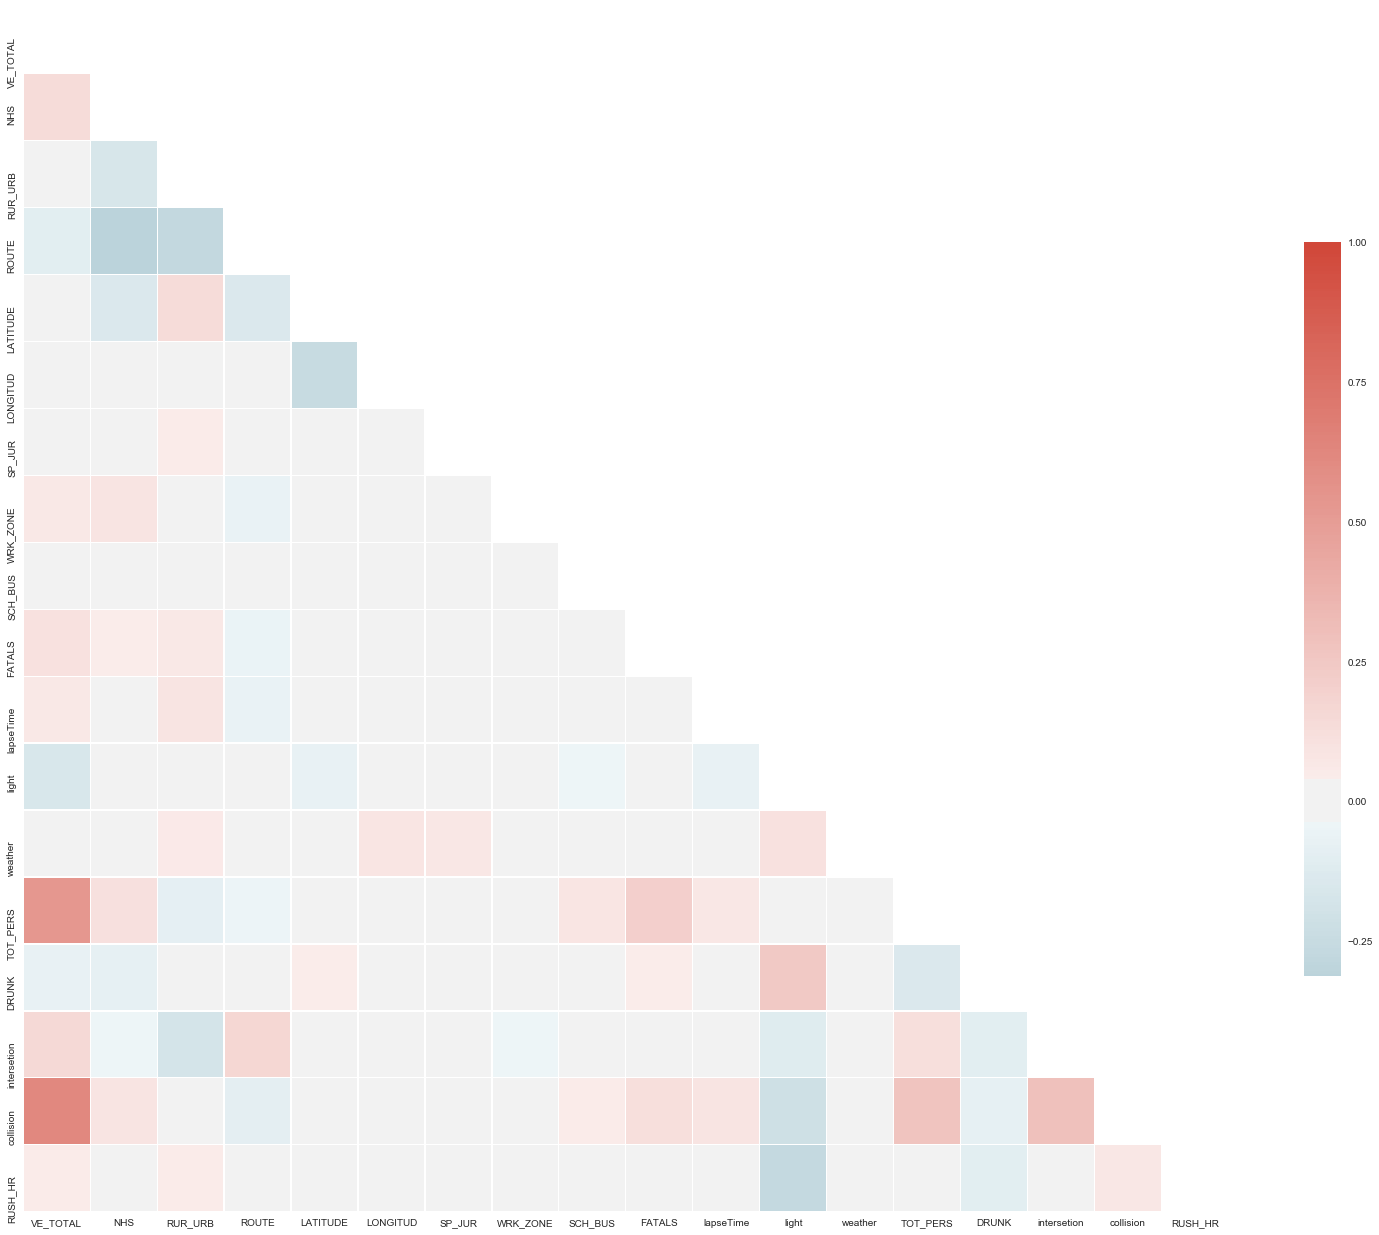

In [27]:
%matplotlib inline

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(27, 27))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 15, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, center=0,
            square=True, linewidths=.2, cbar_kws={"shrink": .5})


**Remove VE_TOTAL**    
From the coorelation plot, we see that total vehicles (VE_TOTAL) is highly coorelated with collisions (collision) and total persons (TOT_PERS).  We will remove VE_TOTAL from the dataset before performing further analysis.

In [28]:
#Drop highly coorelated attributes (VE_TOTAL) 
df.info()

# Drop the highly correlated features from our training data 
df = df.drop('VE_TOTAL', axis=1)

#Check columns after drop 
print('*********************************************')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32166 entries, 0 to 32165
Data columns (total 18 columns):
VE_TOTAL       32166 non-null int64
NHS            32166 non-null int64
RUR_URB        32166 non-null int64
ROUTE          32166 non-null int64
LATITUDE       32166 non-null float64
LONGITUD       32166 non-null float64
SP_JUR         32166 non-null int64
WRK_ZONE       32166 non-null int64
SCH_BUS        32166 non-null int64
FATALS         32166 non-null int64
lapseTime      32166 non-null int64
light          32166 non-null int64
weather        32166 non-null int64
TOT_PERS       32166 non-null int64
DRUNK          32166 non-null int64
intersetion    32166 non-null int64
collision      32166 non-null int64
RUSH_HR        32166 non-null int64
dtypes: float64(2), int64(16)
memory usage: 4.4 MB
*********************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32166 entries, 0 to 32165
Data columns (total 17 columns):
NHS            32166 non-null int

### Clean Dataset

Our clean dataset now contains 17 attributes.  The following table provides the type and scale of each attribute:

|Attribute|Description|Format|Key|
|:-------------|:---------------------------------------------|:---------------|:-------------|
|NHS |Did the accident occur on a national highway? |INTEGER |0-No, 1-Yes |
|RUR_URB |Did the accident occur in an urban area? |INTEGER | 0-Rural, 1-Urban|
|ROUTE |Route signing |INTEGER | 1-Interstate, 2-US Highway, 3-State Highway, 4-County Road, 5-Local Street Township, 6-Local Street Municipality, 7-Local Street Frontage Road, 8-Other, 9-Unknown |
|LATITUDE |Latitude of crash site |FLOAT |DD.DDDD Decimal Degrees, 0-Not available |
|LONGITUDE |Longitude of crash site |FLOAT |DDD.DDDD Decimal Degrees, 0-Not available |
|SP_JUR |Did the accident occur in a special jurisdiction? |INTEGER |0-No, 1-Yes |
|WRK_ZONE |Did the accident occur in a work zone? |INTEGER |0-No, 1-Yes |
|SCH_BUS |Was a school bus involved? |INTEGER |0-No, 1-Yes, --Not reported |
|FATALS |Fatalities |INTEGER |Number of fatalities that occured in crash |
|lapsetime |Time lapse between accident and arrival at hospital |INTEGER |Time in minutes |
|light |Lighting condition at time of accident |INTEGER |1-6 (best to worst) |
|weather |Weather condition at time of accident |INTEGER |1-7 (best to worst) |
|TOT_PERS |Total number of persons involved in the accident |INTEGER |Number of persons |
|DRUNK |Was a drunk driver involved in the crash? |INTEGER |0-No, 1-Yes |
|intersection |Did the accident occur at an intersection? |INTEGER |0-No, 1-Yes |
|collision |Was there a collision involved? |INTEGER |0-No, 1-Yes |
|RUSH_HR |Did the accident occur during rush hour? |INTEGER |0-No, 1-Yes |

# MODELING and EVALUATION


## Clustering of Lighting conditions and Weather

**We will attempt to classify accidents as single-fatality or multiple-fatality accidents**    

Using clustering, we will attempt to classify the accidents in our dataset as to whether they result in single or multiple fatalities.  In particular, the kmeans, hierarchical agglomerative, and DBSCAN clustering methods will be utilized in the classification exercise. The variables used for these clustering exercises will be those representing light conditions, weather conditions, rush hour, drunk persons, and total persons involved in the accidents.

Since the data is extremely skewed toward single-fatality accidents, a stratified 10-fold cross-validation will be used to determine the initial average accuracy when classifying whether a fatal accident results in just one or more than one fatality. 


## Train, Evaluate and Visulize

In [30]:
# Perform cluster analysis using several clustering methods (adjust parameters).

# # now use this grouping to fill the data set in each group, then transform back
# fill in the numeric values
df_imputed = df.transform(lambda grp: grp.fillna(grp.median()))

#Baseline Analysis 
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

y = df_imputed['FATALS']
X = df_imputed[['light','weather','RUSH_HR','DRUNK','TOT_PERS']]
cv = StratifiedKFold(n_splits=10)

clf = RandomForestClassifier(n_estimators=150,random_state=1)

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy =  92.4330138629 +- 0.158762488498


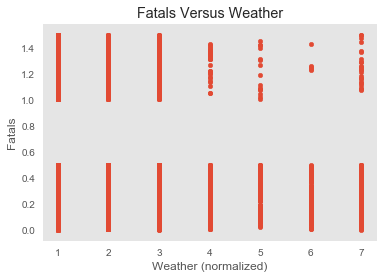

In [31]:
#Plotting Fatals versus Weather 
from matplotlib import pyplot as plt
plt.style.use("ggplot")

%matplotlib inline
X1 = df_imputed[['FATALS','weather']].values

plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 1].shape)/2, 
             s=20)
plt.xlabel('Weather (normalized)'), plt.ylabel('Fatals')
plt.grid()
plt.title('Fatals Versus Weather')
plt.show()

The plot above is a visual reputation of the relationship between FATALS and Weather. Due to the nature and characters of Weather, the visualization is quite categorical and contains distinct groupings/clusters. 

In [32]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

X1 = df_imputed[['light','weather']]

cls = KMeans(n_clusters=8, init='k-means++',random_state=1)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = df_imputed['FATALS']
X = df_imputed[['DRUNK','RUSH_HR','TOT_PERS']]
X = np.column_stack((X,pd.get_dummies(newfeature)))

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy (with kmeans for FATALS/weather/light)= ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy (with kmeans for FATALS/weather/light)=  92.5729025064 +- 0.072890618547


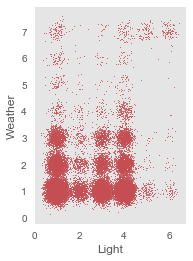

In [33]:
# getting things started
%matplotlib inline

import time
import matplotlib.pyplot as plt
import numpy as np

X1 += .2 * np.random.randn(X1.shape[0],2) # add some randomness


plt.subplot(1,2,2)
plt.plot(X1.values[:, 0], X1.values[:, 1], 'r.', markersize=2) #plot the data
plt.xlabel('Light'), plt.ylabel('Weather')
plt.grid()

plt.show()

The graph above shows the relation between lighting and weather.  From this plot, we can see that there are several potential clusters that can be formed from this relationship.

In [34]:
from sklearn.cluster import KMeans
import numpy as np

X2 = df_imputed[['RUSH_HR','TOT_PERS']]

cls = KMeans(n_clusters=8, init='k-means++',random_state=1)
cls.fit(X2)
newfeature = cls.labels_ # the labels from kmeans clustering

y = df_imputed['FATALS']
X = df_imputed[['DRUNK','light','weather']]

X = np.column_stack((X,pd.get_dummies(newfeature)))

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy (with kmeans for FATALS/RUSH_HR/TOT_PERS)= ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy (with kmeans for FATALS/RUSH_HR/TOT_PERS)=  92.5666894004 +- 0.138423811655


In [16]:
# get the first clustering
cls_fare = KMeans(n_clusters=8, init='k-means++',random_state=1)
cls_fare.fit(X1)
newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

# append on the second clustering
cls_fam = KMeans(n_clusters=8, init='k-means++',random_state=1)
cls_fam.fit(X2)
newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

y = df_imputed['FATALS']
X = df_imputed[['DRUNK']]
X = np.column_stack((X,pd.get_dummies(newfeature_fare),pd.get_dummies(newfeature_fam)))

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy =  92.6817111211 +- 0.0255698391782


In [15]:
%%time 

X1 = df_imputed[['light','weather']]
X2 = df_imputed[['RUSH_HR','TOT_PERS']]

params = []
for n_fare in range(4,10):
    for n_fam in range(16,19):
        # get the first clustering
        cls_fare = KMeans(n_clusters=n_fare, init='k-means++',random_state=1)
        cls_fare.fit(X1)
        newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

        # append on the second clustering
        cls_fam = KMeans(n_clusters=n_fam, init='k-means++',random_state=1)
        cls_fam.fit(X2)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        y = df_imputed['FATALS']
        X = df_imputed[['DRUNK']]
        X = np.column_stack((X,pd.get_dummies(newfeature_fare),pd.get_dummies(newfeature_fam)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

        print ("Clusters",n_fare,n_fam,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Clusters 4 16 Average accuracy =  92.6723827629 +- 0.0447644346415
Clusters 4 17 Average accuracy =  92.6723827629 +- 0.0447644346415
Clusters 4 18 Average accuracy =  92.6723827629 +- 0.0402132659206
Clusters 5 16 Average accuracy =  92.6817130543 +- 0.0422537491516
Clusters 5 17 Average accuracy =  92.672384696 +- 0.0249389830899
Clusters 5 18 Average accuracy =  92.6506214266 +- 0.0658805960423
Clusters 6 16 Average accuracy =  92.6723837295 +- 0.0375429155227
Clusters 6 17 Average accuracy =  92.6630573044 +- 0.04223441782
Clusters 6 18 Average accuracy =  92.6350770626 +- 0.055104435195
Clusters 7 16 Average accuracy =  92.6630573044 +- 0.0373748310293
Clusters 7 17 Average accuracy =  92.6568403321 +- 0.0416335609957
Clusters 7 18 Average accuracy =  92.6350780292 +- 0.0494148377347
Clusters 8 16 Average accuracy =  92.6599488182 +- 0.035845471074
Clusters 8 17 Average accuracy =  92.6412959681 +- 0.0373511793057
Clusters 8 18 Average accuracy =  92.6133166929 +- 0.0320810291383


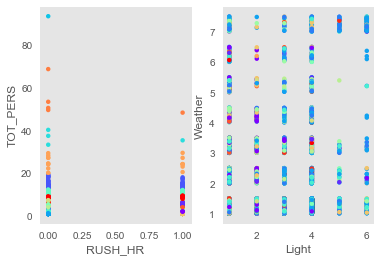

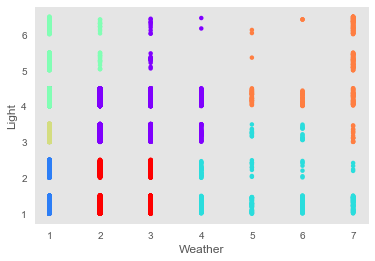

In [61]:
n_fare=7
d_fam=17

X1 = df_imputed[['light','weather']]
X2 = df_imputed[['RUSH_HR','TOT_PERS']]

cls_fare = KMeans(n_clusters=n_fare, init='k-means++',random_state=1)
cls_fare.fit(X1)
newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

# append on the second clustering
cls_fam = KMeans(n_clusters=n_fam, init='k-means++',random_state=1)
cls_fam.fit(X2)
newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

plt.figure()
plt.subplot(1,2,1)
X2=X2.values
plt.scatter(X2[:, 0], X2[:, 1]+np.random.random(X2[:, 1].shape)/2, c=newfeature_fam, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('RUSH_HR'), plt.ylabel('TOT_PERS')
plt.grid()

plt.subplot(1,2,2)
plt.scatter(X1.values[:, 0], X1.values[:, 1]+np.random.random(X1.values[:, 1].shape)/2, c=newfeature_fam, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Light'), plt.ylabel('Weather')
plt.grid()

X1=X1.values
plt.figure()
plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 0].shape)/2, c=newfeature_fare, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Weather'), plt.ylabel('Light')
plt.grid()

The plots above represent the relationships between the features in our dataset. Plot 1 = Relationship between RUSH_HR versus TOT_PERS. Plot 2 = Relationship betwen Light versuss Weather. Plot 3 = Relationship between Weather versus Light. 

In [45]:
params = []
for n_fam in range(15,20):

    # append on the clustering
    cls_fam = KMeans(n_clusters=n_fam, init='k-means++',random_state=1)
    cls_fam.fit(X2)
    newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

    y = df_imputed['FATALS']
    X = df_imputed[['light','weather','RUSH_HR','DRUNK','TOT_PERS']]
    X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

    acc = cross_val_score(clf,X,y=y,cv=cv)
    params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

    print ("Clusters",n_fam,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Clusters 15 Average accuracy =  92.4392308353 +- 0.151699329809
Clusters 16 Average accuracy =  92.4361223491 +- 0.149922561145
Clusters 17 Average accuracy =  92.4267949574 +- 0.158815902583
Clusters 18 Average accuracy =  92.4609931381 +- 0.150704111856
Clusters 19 Average accuracy =  92.4547771324 +- 0.174845938231


In [48]:
%%time 

from sklearn.cluster import AgglomerativeClustering

X1 = df_imputed[['light','weather']]

params = []
for link in ['ward', 'complete', 'average']:
    for n_fam in range(13,20):

        # append on the clustering
        cls_fam = AgglomerativeClustering(n_clusters=n_fam, linkage=link)
        cls_fam.fit(X2)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        y = df_imputed['FATALS']
        X = df_imputed[['light','weather','RUSH_HR','DRUNK','TOT_PERS']]
        X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

        print ("C=",n_fam,link,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

C= 13 ward Average accuracy =  92.4423393214 +- 0.154029775599
C= 14 ward Average accuracy =  92.4392308353 +- 0.16216880464
C= 15 ward Average accuracy =  92.4330128964 +- 0.159413616951
C= 16 ward Average accuracy =  92.4330138629 +- 0.16057798395
C= 17 ward Average accuracy =  92.426795924 +- 0.161786438766
C= 18 ward Average accuracy =  92.4330138629 +- 0.168221368334
C= 19 ward Average accuracy =  92.4299053768 +- 0.161190255115
C= 13 complete Average accuracy =  92.4236874378 +- 0.172099963839
C= 14 complete Average accuracy =  92.4267988237 +- 0.174310382341
C= 15 complete Average accuracy =  92.4236874378 +- 0.172098916177
C= 16 complete Average accuracy =  92.4236884044 +- 0.174843253828
C= 17 complete Average accuracy =  92.4330148295 +- 0.160532763418
C= 18 complete Average accuracy =  92.4330157961 +- 0.156833430684
C= 19 complete Average accuracy =  92.4392308353 +- 0.162763186016
C= 13 average Average accuracy =  92.4267968906 +- 0.169897893259
C= 14 average Average accur

In [49]:
%%time 

from sklearn.cluster import DBSCAN

params = []
for eps in [0.1, 0.125, 0.15]:
    for mpts in range(5,8):

        # append on the clustering
        cls_fam = DBSCAN(eps=eps, min_samples=mpts)
        cls_fam.fit(X2)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        y = df_imputed['FATALS']
        X = df_imputed[['light','weather','RUSH_HR','DRUNK','TOT_PERS']]
        X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

        print (eps,mpts,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

0.1 5 Average accuracy =  92.4547780989 +- 0.157347024393
0.1 6 Average accuracy =  92.4672130102 +- 0.165751382323
0.1 7 Average accuracy =  92.4547780989 +- 0.160390760706
0.125 5 Average accuracy =  92.4547780989 +- 0.157347024393
0.125 6 Average accuracy =  92.4672130102 +- 0.165751382323
0.125 7 Average accuracy =  92.4547780989 +- 0.160390760706
0.15 5 Average accuracy =  92.4547780989 +- 0.157347024393
0.15 6 Average accuracy =  92.4672130102 +- 0.165751382323
0.15 7 Average accuracy =  92.4547780989 +- 0.160390760706
Wall time: 3min 30s


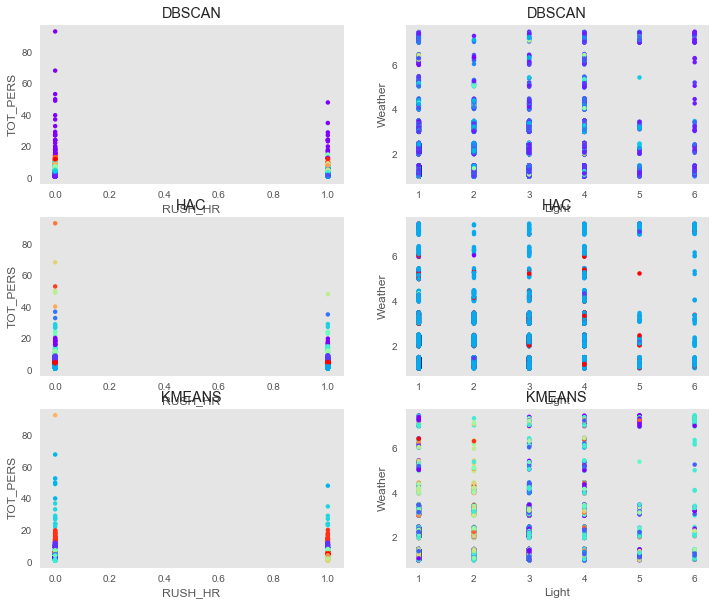

In [66]:
data = X2
data1 = X1

cls = DBSCAN(eps=0.125, min_samples=6)
cls.fit(data)
dbs_labels = cls.labels_ 

cls = AgglomerativeClustering(n_clusters=14, linkage='complete')
cls.fit(data)
hac_labels = cls.labels_ 

cls = KMeans(n_clusters=17, random_state=1)
cls.fit(data)
kmn_labels = cls.labels_

fig = plt.figure(figsize=(12,10))
title = ['DBSCAN','HAC','KMEANS']

for i,l in enumerate([dbs_labels,hac_labels,kmn_labels]):
    
    plt.subplot(3,2,2*i+1)
    plt.scatter(data[:, 0], data[:, 1]+np.random.random(data[:, 1].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('RUSH_HR'), plt.ylabel('TOT_PERS')
    plt.grid()
    plt.title(title[i])
    
    plt.subplot(3,2,2*i+2)
    plt.scatter(data1[:, 0], data1[:, 1]+np.random.random(data[:, 1].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('Light'), plt.ylabel('Weather')
    plt.grid()
    plt.title(title[i])

The plots above contain the different clustering algorithms: DBSCAN, HAC, and KMEANS. The first plot for each algorithm compares the relationship between RUSH_HR versus TOT_PERS. THen, the second plot visualize the relationship between Light versus Weather. 

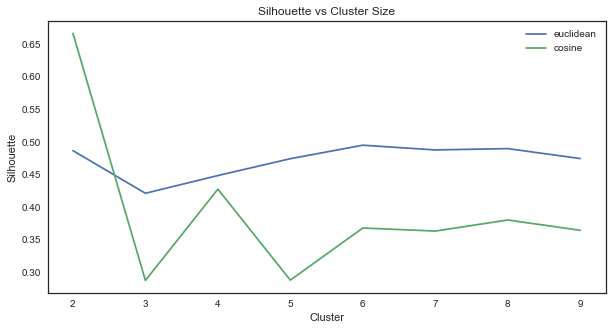

In [21]:
# do it for the k-means
from sklearn.cluster import KMeans

seuclid = []
scosine = []
k = range(2,10)
for i in k:
    kmeans_model = KMeans(n_clusters=i, init="k-means++").fit(data)
    labels = kmeans_model.labels_
    seuclid.append(metrics.silhouette_score(data, labels, metric='euclidean'))
    scosine.append(metrics.silhouette_score(data, labels, metric='cosine'))
    
plt.figure(figsize=(10,5))
plt.plot(k,seuclid,label='euclidean')
plt.plot(k,scosine,label='cosine')
plt.ylabel("Silhouette")
plt.xlabel("Cluster")
plt.title("Silhouette vs Cluster Size")
plt.legend()
plt.show()

## Summarize the Ramifications


Clustering for our dataset didn't prove to be particularly useful.  The dataset consists primarily of categorical variables and only a few ordinal variables which we performed clustering on.  The accuracy of the model is driven largely by the overwheming number of single fatality accidents, and therefore clustering doesn't modify the overall accuracy result very much, with the accuracy of predicting single fatality accidents hovering aroud 92%.

The best result we found, involved the clustering of weather condition and light condition, as well as rush hour traffic and total persons involved.  Clustering these variables increased our model accuracy from 92.43 +- 0.16 to an accuracy of 92.68 +- .04 using a cluster of size 5 for light and weather, and a cluster of size 16 for RUSH_HR and TOT_PERS.  This combination of clusters provided our best overall accuracy using a K-Means algorithm.

Intuitively it makes since that lighting and weather would be related and cluster fairly well.  Similarly, rush hour traffic and total persons are related and also cluster fairly well.  

Ultimately, only a marginal impact is shown using clustering for predicting fatalities which isn't surprising considering the large amount of categorical data and the influence of an overwhelming number of single fatality accidents.


# Deployment

The critical factors for prediction of multi-fatality accidents could be valuable to many government agencies.  Cluster analysis shows the relationship between many of these variables, such as lighting and weather or rush hour and total persons involved in the accident.   Understanding the primary factors that contribute the most to loss of life in motor vehicle accidents, prevention programs can be established to educate and address these causes. Most people would speculate that drunk driving leads to more fatalities, and the model confirms that multiple fatalities are strongly correlated to drunk driving. This can also be clustered with other related factors to reduce the complexity of the analysis.  This information can be used in defensive driving training to stress collision avoidance as a means of staying alive.

Further analysis on predicting what factors are most critical in accidents without fatalities could also prove to be very useful.  Our dataset is only comprised of accidents resulting in fatalities.  As a form of predicting prevention measures, analyzing accidents that avoided fatalities could be very valuable. 

Overall, we were sucessful in showing the major factors involved in fatal accidents.  New data is released each year on traffic fatalities, and this analysis could be updated annually, and even a look at trends over multiple years could be enlightening. 


# Exceptional Work


For exceptional work, mulitple models were used to achieve the best result for our model.  K-Means and DBSCAN were both used in the analysis.  

We also used **euclidean and cosine intercluster distance** to review the optimal number of clusters to achieve the best results for our model.

**New features** were developed from the dataset.  The feature RUSH_HR was created to determine if rush hour traffic was a key factor in fatalities, and was clustered with total persons in our cluster analysis.

**New ordinal variables** were also created for lighting condition and weather condition, which were used in the clustering models.  The original variables for lighting (LGT_COND) was reordered to represent a new ordinal variable (light) to scale from lightest to darkest conditions.  Similarly, the original variable for weather condition (WEATHER) was reordered to represent a new ordinal variable (weather) to scale from best to worst weather conditions.
